This notebook will make an animated visualization of the solar system using positions calculated by `astropy` ephemeris functions.  Basically, it needs a standard Anaconda install, plus 

`conda install opencv`

to get the `cv2` package for making movies from stills.

In [1]:
import numpy as np
import pylab as plt
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body
import cv2
from glob import glob
import sys
sys.path.append('../.')
from ja import Timer, progress_bar as ProgressBar

In [2]:
# Times
# Total time interval, and the timestep
time_interval = 33 * 365 * u.day  # 11 years
dt_approx = 10*u.day
t0 = Time('2020-06-22 12:00:00')
#
nsteps = int((time_interval/dt_approx).to(u.dimensionless_unscaled).value)
time_steps, dt = np.linspace(0, time_interval.value,num=nsteps, retstep=True)
time_steps = time_steps*u.day
dt = dt*u.day
times = t0 + time_steps
# You can compare two time objects, and this allows us to extract smaller time intervals
#test = times[times < t0 + 365*u.day]

In [3]:
def BodyPolarCoords(body, times):
    """ Given a solar system body name and desired times, calculates geocentric and
    heliocentric polar coordinates in the ecliptic plane """
    body_ephem = get_body(body, times)
    r_geo = body_ephem.geocentricmeanecliptic.distance.to(u.AU)
    theta_geo = body_ephem.geocentricmeanecliptic.lon
    r_hel = body_ephem.barycentrictrueecliptic.distance.to(u.AU)
    theta_hel = body_ephem.barycentrictrueecliptic.lon
    return {'r_geo': r_geo, 'theta_geo': theta_geo, 
            'r_hel': r_hel, 'theta_hel': theta_hel,
            'ephem':body_ephem}

In [4]:
body_names = ['moon','sun','mercury','venus','earth','mars','jupiter']
body_colors = ['green','orange','cyan','magenta','blue','red','brown']

In [5]:
%%time
coords = {}

for color, name in zip(body_colors, body_names):
    coords[name] = BodyPolarCoords(name, times)  
    coords[name]['color'] = color

CPU times: user 7.34 s, sys: 83.6 ms, total: 7.42 s
Wall time: 7.63 s


In [6]:
coords['sun']

{'r_geo': <Distance [1.01639629, 1.01668774, 1.01657809, ..., 1.01284046, 1.01443406,
            1.01568609] AU>,
 'theta_geo': <Longitude [ 91.24089363, 100.7892948 , 110.33237245, ...,  63.98621298,
              73.58584402,  83.16177167] deg>,
 'r_hel': <Distance [0.00868804, 0.00870525, 0.00872201, ..., 0.00319866, 0.00320983,
            0.00322119] AU>,
 'theta_hel': <Longitude [126.94046274, 127.51793285, 128.09564399, ...,  54.37071657,
              55.44488037,  56.51842495] deg>,
 'ephem': <SkyCoord (GCRS: obstime=['2020-06-22 12:00:00.000' '2020-07-02 12:17:57.307'
  '2020-07-12 12:35:54.613' ... '2053-05-25 11:24:05.387'
  '2053-06-04 11:42:02.693' '2053-06-14 12:00:00.000'], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
     [( 91.35243056, 23.43085747, 1.01639629),
      (101.73361452, 22.998367  , 1.01668774),
      (111.99243194, 21.89772991, 1.01657809), ...,
      ( 61.99173827, 20.93893208, 1.01284046),
      ( 72.2

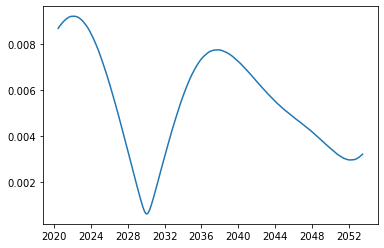

In [7]:
plt.plot(times.datetime,coords['sun']['r_hel'])

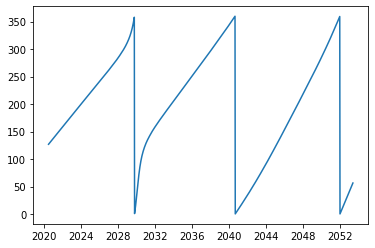

In [8]:
plt.plot(times.datetime,coords['sun']['theta_hel'])

In [9]:
c.R_sun.to('AU')

<Quantity 0.00465047 AU>

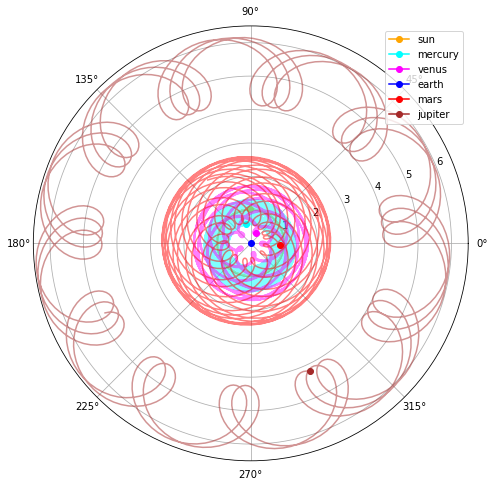

In [10]:
plt.figure(figsize=(8,8))

names = ['sun','mercury','venus','earth', 'mars','jupiter']
for name in names:
    
    # Starting point
    plt.polar(coords[name]['theta_geo'].rad[0],
              coords[name]['r_geo'][0].value, 
              marker='o', color=coords[name]['color'], label=name)
    
    # Track
    plt.polar(coords[name]['theta_geo'].rad,
              coords[name]['r_geo'].value,
              alpha=0.5,color=coords[name]['color'])


ax=plt.gca()
ax.set_rlim(0,6.5)
plt.legend()
plt.show()

In [11]:
coords['sun']['ephem'].barycentrictrueecliptic.cartesian.x

<Quantity [-0.00522124, -0.00530144, -0.00538111, ...,  0.00186334,
            0.0018206 ,  0.00177702] AU>

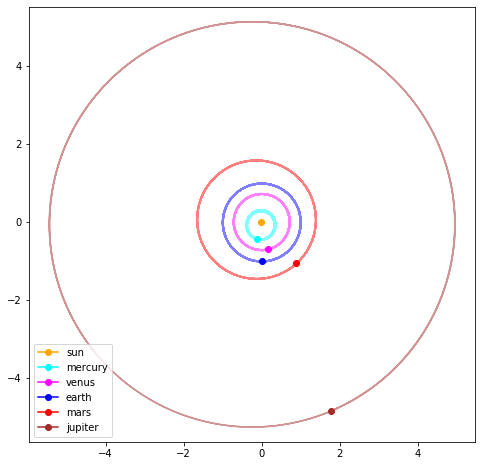

In [12]:
plt.figure(figsize=(8,8))

names = ['sun','mercury','venus','earth', 'mars','jupiter']
for name in names:
    
    # Starting point
    plt.plot(coords[name]['ephem'].barycentrictrueecliptic.cartesian.x[0],
             coords[name]['ephem'].barycentrictrueecliptic.cartesian.y[0], 
              marker='o', color=coords[name]['color'], label=name)
    
    # Track
    plt.plot(coords[name]['ephem'].barycentrictrueecliptic.cartesian.x,
              coords[name]['ephem'].barycentrictrueecliptic.cartesian.y, 
              alpha=0.5,color=coords[name]['color'],marker='')

#ax=plt.gca()
#ax.set_rlim(-1,1) 

plt.axis('equal')
plt.legend()
plt.show()

(-0.009895271101483095,
 0.007836219423347035,
 -0.00841452152387953,
 0.007675172331868669)

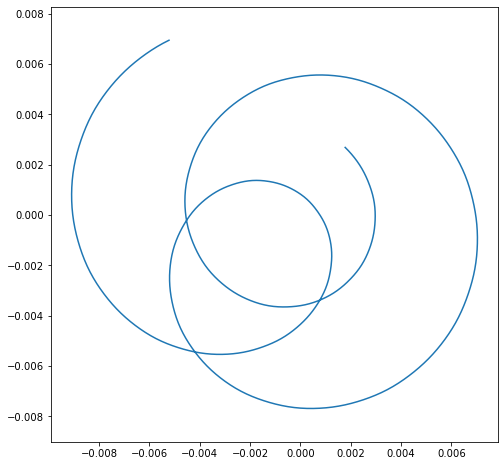

In [13]:
plt.figure(figsize=(8,8))
plt.plot(coords['sun']['ephem'].barycentrictrueecliptic.cartesian.x, coords['sun']['ephem'].barycentrictrueecliptic.cartesian.y)
plt.axis('equal')

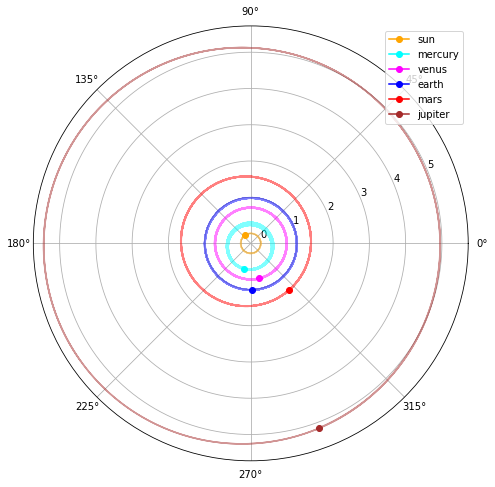

In [14]:
plt.figure(figsize=(8,8))

names = ['sun','mercury','venus','earth', 'mars','jupiter']
for name in names:
    
    # Starting point
    plt.polar(coords[name]['theta_hel'].rad[0],
              coords[name]['r_hel'][0].value, 
              marker='o', color=coords[name]['color'], label=name)
    
    # Track
    plt.polar(coords[name]['theta_hel'].rad,
              coords[name]['r_hel'].value,
              alpha=0.5,color=coords[name]['color'])

#ax=plt.gca()
#ax.set_rlim(-1,1) 
    
plt.legend()
plt.show()

In [15]:
def Orrery(i, dirname = '', heliocentric=True, rlim=6.5):
    
    
    if heliocentric:
        theta = 'theta_hel'
        r = 'r_hel'
    else:
        theta = 'theta_geo'
        r = 'r_geo'

    plt.figure(figsize=(8,8))

    names = ['sun','mercury','venus','earth', 'mars','jupiter']
    for name in names:
    
    # Current location
        plt.polar(coords[name][theta].rad[i],
                  coords[name][r][i].value, 
                  marker='o', color=coords[name]['color'], label=name)
    
    # Track till now
        start_track = 0 #np.max([0,i-300])
        plt.polar(coords[name][theta].rad[start_track:i],
                  coords[name][r][start_track:i].value,
                  alpha=0.5,color=coords[name]['color'])

    ax=plt.gca()
    ax.set_rlim(0,rlim) 
        
    plt.legend(loc='upper right')
    plt.savefig(dirname+'/orrery'+str(i).zfill(4)+'.png')
    plt.close()

In [16]:
def MovieFromFileDir(filedir, movie_filename, fps=20):
    
    files = glob(filedir+'/orrery????.png')
    files.sort()
    
    # Read the initial frame to get the size
    img = cv2.imread(files[0])
    height, width, layers = img.shape
    size = (width,height)
    
    out = cv2.VideoWriter(movie_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for fn in files:

        img = cv2.imread(fn)
        out.write(img)

    out.release()
    
    return

In [18]:
%%time
timer = Timer()
timer.start()
indx = np.arange(0,len(times),3)
ntimes = np.max(indx)
for i in indx:
    ProgressBar(i/ntimes)
    Orrery(i, heliocentric=True, dirname='orrery_heliocen', rlim=5.5)
timer.stop('Took ')

Progress: [####################] 100.0%
Took  81.97423100471497 sec
CPU times: user 1min 17s, sys: 3.05 s, total: 1min 20s
Wall time: 1min 21s


In [19]:
%%time
MovieFromFileDir('orrery_heliocen', 'orrery_heliocen.mp4')

CPU times: user 2.41 s, sys: 224 ms, total: 2.63 s
Wall time: 2.85 s


In [ ]:
%%time
timer = Timer()
timer.start()
indx = np.arange(0,len(times),3)
ntimes = np.max(indx)
for i in indx:
    ProgressBar(i/ntimes)
    Orrery(i, heliocentric=False, dirname='orrery_geocen', rlim=6.5)
timer.stop('Took ')

Progress: [#######-------------] 32.9%


In [68]:
%%time
MovieFromFileDir('orrery_geocen', 'orrery_geocen.mp4')